In [270]:
# import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

import pandas_pipeline_classes as ppc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler

from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score

from keras.callbacks import History , EarlyStopping, TensorBoard
history = History()

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [2]:
# read data
houses = pd.read_csv('houses.csv').drop('Id', axis=1)

In [3]:
# preprocessing pipeline
numPipe = Pipeline([
    ('selectNum', ppc.DFTransform(lambda X: X.select_dtypes(exclude=[object]))),
    ('Imputer', ppc.DFImputer(imputer=Imputer(strategy='median')))
])

In [4]:
catPipe = Pipeline([
    ('selectCat', ppc.DFTransform(lambda X: X.select_dtypes(include=[object]))),
    ('Imputer', ppc.DFTransform(lambda X: X.fillna('NaN'))),
    ('oneHot', ppc.DFDummyTransformer())
])

In [272]:
finalPipe = Pipeline([
    ('dropCols', ppc.DropTooManyNulls()),
    ('union', ppc.DFFeatureUnion([
        ('num', numPipe)
        ,('cat', catPipe)
    ])),
        ('scaler', RobustScaler()),
    #('scaler', ppc.DFScaler(scaler=StandardScaler()))
])

In [195]:
features = houses.drop('SalePrice', axis=1)
target = houses['SalePrice']

In [196]:
from sklearn.cross_validation import train_test_split

In [213]:
X_train, X_test, y_train, y_test = train_test_split(features, np.log(target), test_size=0.2)

In [319]:
# build keras model
def myModel():
    model = Sequential()
    model.add(Dense(10000, input_dim=277, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='linear'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['mse', 'mae', 'mape', r2_keras])
    return model

In [320]:
finalPipe.fit_transform(X_train).shape


(1168, 277)

In [321]:
estimator = KerasRegressor(build_fn=myModel, epochs=200)

In [322]:
modelPipe = Pipeline([
     ('dropCols', ppc.DropTooManyNulls()),
    ('union', ppc.DFFeatureUnion([
        ('num', numPipe)
        ,('cat', catPipe)
    ])),
    ('scaler', ppc.DFScaler(scaler=RobustScaler())),
    #('scaler', StandardScaler()),
    ('NN', estimator)
])

In [276]:
cross_val_score(estimator=modelPipe, X=X_train, y=y_train, fit_params={'NN__epochs':100, 'NN__callbacks':[history]}, scoring='r2')

ValueError: Error when checking input: expected dense_108_input to have shape (None, 277) but got array with shape (778, 266)

In [323]:
modelPipe.fit(X_train, y_train)

Epoch 1/200
1168/1168 [==============================] - 3s 2ms/step - loss: 17965.2648 - mean_squared_error: 17965.2648 - mean_absolute_error: 41.3573 - mean_absolute_percentage_error: 344.8045 - r2_keras: -135145.4184
Epoch 2/200
1168/1168 [==============================] - 2s 1ms/step - loss: 100189.1044 - mean_squared_error: 100189.1044 - mean_absolute_error: 33.7808 - mean_absolute_percentage_error: 281.2445 - r2_keras: -1035666.3077
Epoch 3/200
1168/1168 [==============================] - 2s 1ms/step - loss: 11227.9764 - mean_squared_error: 11227.9764 - mean_absolute_error: 17.2399 - mean_absolute_percentage_error: 143.2260 - r2_keras: -81749.3874
Epoch 4/200
1168/1168 [==============================] - 2s 1ms/step - loss: 1590.3029 - mean_squared_error: 1590.3029 - mean_absolute_error: 6.9642 - mean_absolute_percentage_error: 57.8142 - r2_keras: -13829.4613
Epoch 5/200
1168/1168 [==============================] - 2s 1ms/step - loss: 15713.5343 - mean_squared_error: 15713.5343 - 

1168/1168 [==============================] - 1s 1ms/step - loss: 2208.6152 - mean_squared_error: 2208.6152 - mean_absolute_error: 8.1290 - mean_absolute_percentage_error: 67.4674 - r2_keras: -22099.2480
Epoch 40/200
1168/1168 [==============================] - 2s 1ms/step - loss: 2493.8665 - mean_squared_error: 2493.8665 - mean_absolute_error: 6.0194 - mean_absolute_percentage_error: 50.1552 - r2_keras: -13156.7929
Epoch 41/200
1168/1168 [==============================] - 2s 1ms/step - loss: 526.9431 - mean_squared_error: 526.9431 - mean_absolute_error: 4.3746 - mean_absolute_percentage_error: 36.4813 - r2_keras: -3332.3753
Epoch 42/200
1168/1168 [==============================] - 2s 1ms/step - loss: 3041.5923 - mean_squared_error: 3041.5923 - mean_absolute_error: 7.6727 - mean_absolute_percentage_error: 63.8926 - r2_keras: -20927.6843
Epoch 43/200
1168/1168 [==============================] - 2s 1ms/step - loss: 738.9870 - mean_squared_error: 738.9870 - mean_absolute_error: 4.5365 - me

KeyboardInterrupt: 

In [308]:
modelPipe.score(X_train, y_train)

1168/1168 [==============================] - 0s 413us/step


-0.0066650561057031155

In [309]:
modelPipe.predict(X_train)

array([ 12.52257824,  12.0710535 ,  11.70643711, ...,  11.74745083,
        11.99650955,  12.31502151], dtype=float32)

In [310]:
from sklearn.metrics import r2_score

In [311]:
r2_score(y_test, modelPipe.predict(X_test))

0.72221240100204742

In [312]:
from seaborn import lmplot
data = pd.DataFrame({'true': y_test, 'pred': modelPipe.predict(X_test)})
data.head()

,pred,true
725,11.668609,11.699405
499,11.714610,11.695247
769,12.967974,13.195614
848,12.273273,12.388394
457,12.355742,12.452933


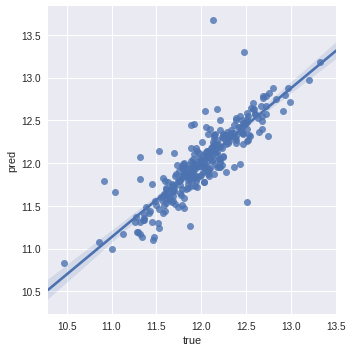

In [313]:
%matplotlib inline
lmplot(data=data, x='true', y='pred')